In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import datetime
from pymongo import MongoClient

In [2]:
client = MongoClient('localhost', 27017)
db = client.moniter_crowdfunding
project = db.projects
f_project = db.failure_projects

In [3]:
def increment(x):
    return [(x[i] - x[i-1]) if i >= 1 else x[0] for i in range(len(x))]

In [4]:
def description(item):
    start_time = item['状态变换时间1-2']
    end_time = item['状态变换时间2-3']

    print(f"项目编号: {item['_id']}\n项目名称: {item['项目名称']}\n所属类别: {item['所属类别']}\n公司名称: {item['公司名称']}")
    print(f"\n众筹期限: {item['众筹期限']}\n项目状态: {item['状态']}")
    print()
    print("发起人页面:", f"http://z.jd.com/project/details/{item['_id']}.html") 
    print("项目页面:", f"http://z.jd.com{item['发起人链接']}")
    print()
    print('预热中:', item['状态变换时间0-1'].strftime('%Y年%m月%d日 %H:%M:%S'), sep='\t') 
    print('预热中->众筹中:', start_time.strftime('%Y年%m月%d日 %H:%M:%S'), sep='\t')
    print('众筹中->众筹成功:', end_time.strftime('%Y年%m月%d日 %H:%M:%S'), sep='\t')
    print('众筹中->项目成功:', item['状态变换时间3-4'].strftime('%Y年%m月%d日 %H:%M:%S'), sep='\t')

In [14]:
def to_df(item):
    dyn_info = item['项目动态信息']
    t_fund = item['目标金额']
    start_t = item['状态变换时间1-2']  # 众筹开始时间
    end_t = item['状态变换时间2-3']  # 众筹成功时间
    # 去除重复
    a1 = dyn_info[0]
    records = {'更新时间':[], '支持者数':[], '关注数':[], '点赞数':[], '完成百分比':[], '筹集金额':[]}
    for i, a2 in enumerate(dyn_info):
        if a2["更新时间"] != a1['更新时间']:
            records['更新时间'].append(a2['更新时间'])
            records['支持者数'].append(a2['支持者数'])
            records['关注数'].append(a2['关注数'])
            records['完成百分比'].append(a2['完成百分比'])
            records['筹集金额'].append(a2['筹集金额'])
            records['点赞数'].append(a2['点赞数'])
            a1 = a2
    # 绘图
    col_names = ['关注数', '支持者数', '点赞数', '完成百分比', '筹集金额']
    df = pd.DataFrame(records, index=records['更新时间'], columns=col_names)
    return df

In [16]:
def getTimeRange(df, start_t):
    x = df[df.index > start_t]
    y = x[x.完成百分比.values > 100]
    d = x[:y.index[0]]
    return d

In [57]:
def getStatus(projs):
    intv_list = []
    relative_intv_list = []
    for i, item in enumerate(projs):
        try:
            start_t = item['状态变换时间1-2']  # 众筹开始时间
            end_t = item['状态变换时间2-3']  # 众筹停止时间
            df = to_df(item)
            t_df = getTimeRange(df, start_t)
            time_interval = (t_df.index[-1] - t_df.index[0]).to_pytimedelta().total_seconds()  # 转化为浮点数(秒)
            tot_inteval = (end_t - start_t).total_seconds()
            intv_list.append(time_interval)  
            relative_intv_list.append(time_interval / tot_inteval)
        except IndexError as e:
            print(i, item['_id'], e)
        except KeyError as k:
            print(i, item['_id'], k)
    return intv_list, relative_intv_list

In [50]:
pd.Timestamp("2012-12-21") - pd.Timestamp("2012-12-1")

Timedelta('20 days 00:00:00')

In [53]:
pd.Timedelta('5:0:0').to_pytimedelta().total_seconds()

18000.0

In [58]:
projs = project.find({"状态": '项目成功'})
status, relative_status = getStatus(projs)

17 98168 index 0 is out of bounds for axis 0 with size 0
38 100361 index 0 is out of bounds for axis 0 with size 0
78 99138 '状态变换时间1-2'
81 99802 index 0 is out of bounds for axis 0 with size 0
89 100375 index 0 is out of bounds for axis 0 with size 0
138 100128 index 0 is out of bounds for axis 0 with size 0
162 100952 index 0 is out of bounds for axis 0 with size 0
166 100224 index 0 is out of bounds for axis 0 with size 0
186 100702 index 0 is out of bounds for axis 0 with size 0
211 101202 index 0 is out of bounds for axis 0 with size 0
222 94039 index 0 is out of bounds for axis 0 with size 0
237 101006 index 0 is out of bounds for axis 0 with size 0
242 101150 index 0 is out of bounds for axis 0 with size 0
357 100551 index 0 is out of bounds for axis 0 with size 0
373 101685 index 0 is out of bounds for axis 0 with size 0
378 101886 index 0 is out of bounds for axis 0 with size 0
380 102009 index 0 is out of bounds for axis 0 with size 0
449 102106 index 0 is out of bounds for ax

absolute status: 1229939.52 pass 0.7 density
relative status: 0.41489151960501763 pass 0.7 density


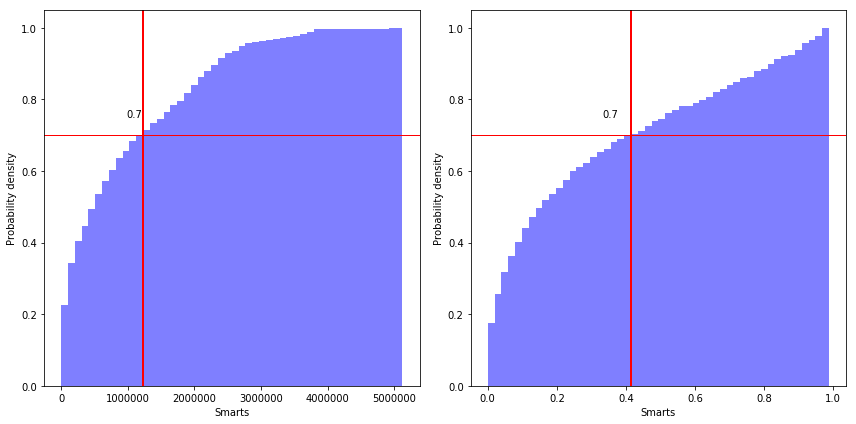

In [124]:
num_bins = 50
fig = plt.figure(figsize=(12, 6))
title = ['absolute status', 'relative status']
# the histogram of the data
num = 0.7
for i, x in enumerate([status, relative_status]):
    ax =fig.add_subplot(1, 2, i+1)
    n, bins, patches = ax.hist(x, num_bins, color='blue', alpha=0.5, density=1, cumulative=True)
    idx = np.argwhere(n == n[n > num][0])[0][0]
    print(f"{title[i]}: {bins[idx]} pass {num} density")
    ax.set_xlabel('Smarts')
    ax.set_ylabel('Probability density')
    ax.axhline(num, color='red', linestyle='-', linewidth=1)
    ax.axvline(bins[idx], color='red', linestyle='-', linewidth=2)
    ax.text(bins[idx]*0.8, num + 0.05, f"{num}")

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

In [92]:
accum_n[accum_n == half_n]

array([18.46850394])